# Explore Portfolio, Transcript and Profile Data

Load cleaned data, perform (visual) exploration.


### Data Sources

Cleaned datafiles, as prepared in notebook 1:
- portfolio_clean.csv - containing offer ids and meta data about each offer (duration, type, etc.)
- profile_clean.csv - demographic data for each customer
- transcript_clean.csv - records for transactions, offers received, offers viewed, and offers completed

### Changes

- 2019-01-08: Started notebook
- 2019-01-10: finished basic visual analysis (round 1)
- 2019-01-16: restarted visual analysis with newly flagged data
- 2019-01-21: finished



In [7]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [8]:
# import preparated data

portfolio_file = Path.cwd() / "data" / "processed" / "portfolio_clean.csv"
profile_file = Path.cwd() / "data" / "processed" / "profile_clean.csv"
transcript_file = Path.cwd() / "data" / "processed" / "transcript_clean.csv"

profile = pd.read_csv(profile_file, index_col = 0, dtype={'gender' : 'category'})
transcript = pd.read_csv(transcript_file)
portfolio = pd.read_csv(portfolio_file, index_col = 0, dtype={'web' : 'category', 'email' : 'category', 'mobile' : 'category',
                                                              'social' : 'category', 'offer_type' : 'category'})

## Explore portfolio data

In [3]:
display(portfolio)
display(portfolio.info())

,difficulty,duration,offer_type,reward,web,email,mobile,social,prop_rewards,rel_difficulty,duration_hours,offer_received,offer_viewed,offer_completed,completed_viewed,receive_to_view,view_to_complete,receive_to_complete,complete_by_accident
offer_id,,,,,,,,,,,,,,,,,,,
o_1,10,7,bogo,10,0.0,1.0,1.0,1.0,1.000000,1.428571,168,7658,6675,3649,2577.0,0.871638,0.386067,0.336511,0.293779
o_2,10,5,bogo,10,1.0,1.0,1.0,1.0,1.000000,2.000000,120,7593,7218,3272,2700.0,0.950612,0.374065,0.355591,0.174817
o_3,5,7,bogo,5,1.0,1.0,1.0,0.0,1.000000,0.714286,168,7677,4122,4302,2098.0,0.536928,0.508976,0.273284,0.512320
o_4,5,5,bogo,5,1.0,1.0,1.0,1.0,1.000000,1.000000,120,7571,7191,4208,3447.0,0.949808,0.479349,0.455290,0.180846
o_5,20,10,discount,5,1.0,1.0,0.0,0.0,0.250000,2.000000,240,7668,2651,3390,1332.0,0.345722,0.502452,0.173709,0.607080
o_6,7,7,discount,3,1.0,1.0,1.0,1.0,0.428571,1.000000,168,7646,7329,5108,4342.0,0.958540,0.592441,0.567879,0.149961
o_7,10,10,discount,2,1.0,1.0,1.0,1.0,0.200000,1.000000,240,7597,7326,5296,4632.0,0.964328,0.632269,0.609714,0.125378
o_8,10,7,discount,2,1.0,1.0,1.0,0.0,0.200000,1.428571,168,7632,4056,3963,2109.0,0.531447,0.519970,0.276336,0.467827
o_9,0,4,informational,0,1.0,1.0,1.0,0.0,NaN,0.000000,96,7617,3752,0,0.0,0.492582,0.000000,0.000000,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, o_1 to o_10
Data columns (total 19 columns):
difficulty              10 non-null int64
duration                10 non-null int64
offer_type              10 non-null category
reward                  10 non-null int64
web                     10 non-null category
email                   10 non-null category
mobile                  10 non-null category
social                  10 non-null category
prop_rewards            8 non-null float64
rel_difficulty          10 non-null float64
duration_hours          10 non-null int64
offer_received          10 non-null int64
offer_viewed            10 non-null int64
offer_completed         10 non-null int64
completed_viewed        10 non-null float64
receive_to_view         10 non-null float64
view_to_complete        10 non-null float64
receive_to_complete     10 non-null float64
complete_by_accident    8 non-null float64
dtypes: category(5), float64(7), int64(7)
memory usage: 1.5+ KB


None

Some Explanations for the newly created columns: 
- `prop rewards`: reward / difficulty
- `rel_difficulty`: difficulty / duration (in days), necessary mean spending per day of duration for completion
- `offer_viewed`and `offer_completed`: counts for events within active duration of offer only
- `completed_viewed`: offers completed after they have been viewed by the user (within duration)
- `receive_to_view`: proportion of offers viewed (within duration) of total offers received
- `view_to_complete`: proportion of offers completed (within duration) of offers viewed (within duration)
- `receive_to_complete`: proportion of offers completed (within duration) of total offers received
- `complete_by_accident`: proportion of offers completed without being viewed of total offers completed

In [4]:
portfolio.describe()

,difficulty,duration,reward,prop_rewards,rel_difficulty,duration_hours,offer_received,offer_viewed,offer_completed,completed_viewed,receive_to_view,view_to_complete,receive_to_complete,complete_by_accident
count,10.000000,10.000000,10.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,8.000000
mean,7.700000,6.500000,4.200000,0.634821,1.057143,156.000000,7627.700000,5635.000000,3318.80000,2323.700000,0.739315,0.399559,0.304831,0.314001
std,5.831905,2.321398,3.583915,0.396806,0.700502,55.713553,34.794795,1798.954079,1868.69139,1589.864358,0.237544,0.224823,0.209022,0.188561
min,0.000000,3.000000,0.000000,0.200000,0.000000,72.000000,7571.000000,2651.000000,0.00000,0.000000,0.345722,0.000000,0.000000,0.125378
25%,5.000000,5.000000,2.000000,0.237500,0.785714,120.000000,7602.000000,4072.500000,3301.50000,1523.500000,0.532817,0.377065,0.198603,0.168603
50%,8.500000,7.000000,4.000000,0.714286,1.000000,168.000000,7625.000000,6352.500000,3806.00000,2343.000000,0.831592,0.490901,0.306424,0.237313
75%,10.000000,7.000000,5.000000,1.000000,1.428571,168.000000,7655.000000,7211.250000,4278.50000,3260.250000,0.950411,0.517222,0.430365,0.478951
max,20.000000,10.000000,10.000000,1.000000,2.000000,240.000000,7677.000000,7329.000000,5296.00000,4632.000000,0.964328,0.632269,0.609714,0.607080


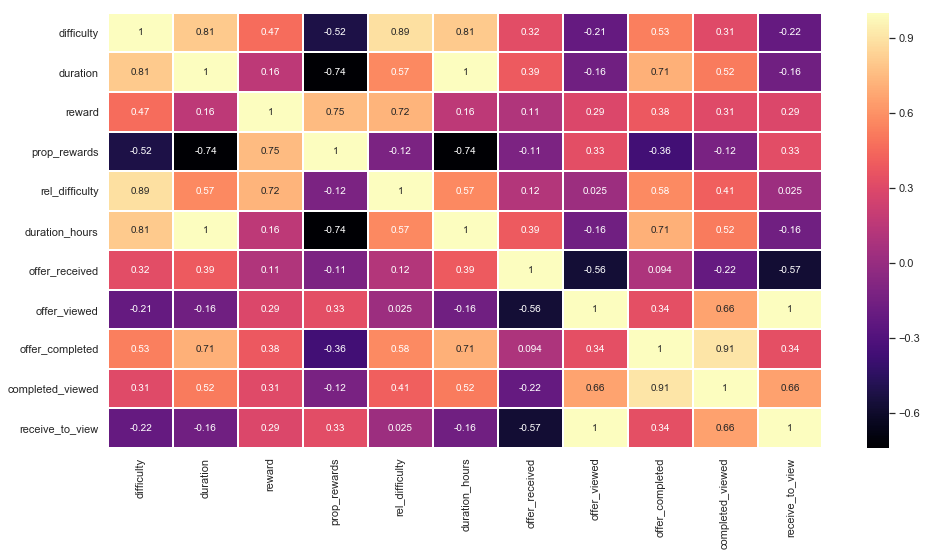

In [5]:
"""show correlation between numerical features (1) - all relations with regard to 'completed' are removed"""

EDA.plot_num_corrMap(portfolio.iloc[: , :-3],  figsize=(16, 8))

**Observations:** Because the non-completion of the informational offers distorts all relations with regard to completion, the respective columns have been removed for this first heatmap plot. The remaining results are not very interesting / surprising, because we are are mainly interested in features leading to high completion rates.

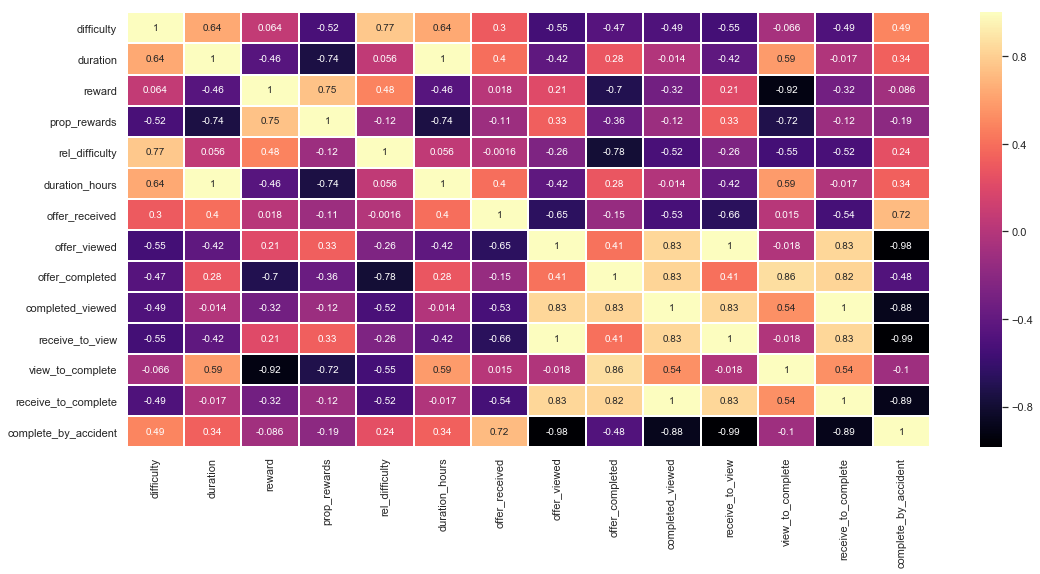

In [6]:
"""show correlation between numerical features (2) - informational offers (o_9 & o_10) are removed"""

EDA.plot_num_corrMap(portfolio.iloc[:-2 , :],  figsize=(18, 8))

**Observations:** Probably the most relevant feature to measure success is `view_to_complete`, the proportion of offers completed (within duration) after being viewed by the customer. We fokus on correlations with that feature.
- higher duration and lower difficulty helps (expected)
- higher reward and prop. reward have strong negative correlation (rather surprising)

**Offer type 'discount' has higher 'view_to_complete'-rates than 'bogo' in general, even when duration or difficulty are the same / higher!**

### Fokus: View rates and channels
What potentially dangerous for all interpretations, if not taken into account are the large differences in the views of the different offers. They are due to the different use of channels for offer communication.


In [7]:
# display relevant colums, sorted by viewed offers

display(portfolio[['web', 'email', 'mobile', 'social', 'duration', 'offer_received', 'offer_viewed', 
                   'receive_to_view', 'complete_by_accident']].sort_values(['offer_viewed'], ascending=False))

,web,email,mobile,social,duration,offer_received,offer_viewed,receive_to_view,complete_by_accident
offer_id,,,,,,,,,
o_6,1.0,1.0,1.0,1.0,7,7646,7329,0.958540,0.149961
o_7,1.0,1.0,1.0,1.0,10,7597,7326,0.964328,0.125378
o_2,1.0,1.0,1.0,1.0,5,7593,7218,0.950612,0.174817
o_4,1.0,1.0,1.0,1.0,5,7571,7191,0.949808,0.180846
o_1,0.0,1.0,1.0,1.0,7,7658,6675,0.871638,0.293779
o_10,0.0,1.0,1.0,1.0,3,7618,6030,0.791546,NaN
o_3,1.0,1.0,1.0,0.0,7,7677,4122,0.536928,0.512320
o_8,1.0,1.0,1.0,0.0,7,7632,4056,0.531447,0.467827
o_9,1.0,1.0,1.0,0.0,4,7617,3752,0.492582,NaN


**Observations:** As can be seen all offers are sent out in more or less the same number (approx. 7'600 per offer). The viewed offers vary dramaticly, due to different channels used:
- View rates around 95% if all channels used
- View rates approx 85% if all channels but web
- View rates approx. 50% if all channels but social
- View rates approx. 35% if web and email only

The lower the view rate the higher the number of offers that are completed (within duration) without customers having viewed them in the first place. The rate is acutally the highest for the most difficult offer by far (o_5).

**We have to fokus on conversion rates starting with actual viewings, all others are distorted.**

### Aggregations by offer type

In [17]:
portfolio_grouped = portfolio.groupby('offer_type').agg(np.mean)
print("Mean Values per Offer Type:")
display(portfolio_grouped[['difficulty', 'duration', 'reward', 'prop_rewards', 
                          'rel_difficulty', 'view_to_complete']])

Mean Values per Offer Type:


,difficulty,duration,reward,prop_rewards,rel_difficulty,view_to_complete
offer_type,,,,,,
bogo,7.50,6.0,7.5,1.000000,1.285714,0.437114
discount,11.75,8.5,3.0,0.269643,1.357143,0.561783
informational,0.00,3.5,0.0,NaN,0.000000,0.000000


## Explore transcript data

To remember: Viewings, completions are only flagged as promo-related if within valid duration period. Transactions are only flagged if within duration and after viewing of an offer. It is possible that a transaction is flagged for more than one offer, if the customer has viewed several active offers in parallel.

In [12]:
display(transcript.head())
display(transcript.info())

,event,person_id,time,amount,offer_id,o_1,o_2,o_3,o_4,o_5,o_6,o_7,o_8,o_9,o_10
0,offer received,p_4,0,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,offer viewed,p_4,6,NaN,o_3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transaction,p_4,132,19.89,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,p_4,132,NaN,o_3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,p_4,144,17.78,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 15 columns):
event        306534 non-null object
person_id    306534 non-null object
time         306534 non-null int64
amount       138953 non-null float64
offer_id     167581 non-null object
o_1          36790 non-null float64
o_2          32185 non-null float64
o_3          30359 non-null float64
o_4          32714 non-null float64
o_5          31399 non-null float64
o_6          39337 non-null float64
o_7          46677 non-null float64
o_8          29930 non-null float64
o_9          19180 non-null float64
o_10         21410 non-null float64
dtypes: float64(11), int64(1), object(3)
memory usage: 35.1+ MB


None

In [13]:
# count total number of transactions
total_transactions = transcript['event'].value_counts()[0]
print("total number of transactions: ", total_transactions)

total number of transactions:  138953


In [14]:
"""check how many transactions are assigned (flagged with 1) to how many active, viewed promotions each"""

assert transcript.columns[-10] == 'o_1' # safety-check
transcript['promo_count'] = transcript.iloc[: , -10:].sum(axis=1)
display(transcript.loc[transcript['event'] == 'transaction']['promo_count'].value_counts())
transcript.drop(['promo_count'], axis=1, inplace=True)

0.0    69765
1.0    63975
2.0     5148
3.0       65
Name: promo_count, dtype: int64

**Observations:**
Of the approx. 139'000 transactions roughly half are assigned to 1 or more promotions.
- approx. 64'000 (96%) to one promotion
- approx. 5150 (4%) to two promotions
- 65 to three promotions

C:\Users\r2d4\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


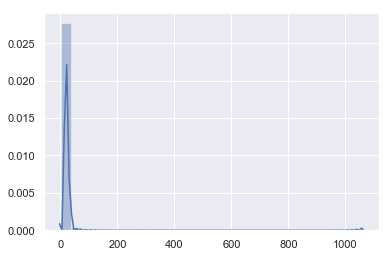

In [15]:
"""check distribution of transaction amounts and remove outliers"""

# display distribution of transaction amounts
amounts_list = [x for x in transcript['amount'] if x >= 0]
sns.distplot(amounts_list, bins=30);

In [16]:
# count outliers (<> IQR=1.5)
cleaning.count_outliers_IQR_method(transcript, outlier_cols=['amount'])

amount
Identified outliers: 1236
Percentage of outliers: 0.4%



In [17]:
cleaning.remove_outliers_IQR_method(transcript)
len(transcript)

time
Rows removed: 0

amount
Rows removed: 1236

o_1
Rows removed: 0

o_2
Rows removed: 0

o_3
Rows removed: 0

o_4
Rows removed: 0

o_5
Rows removed: 0

o_6
Rows removed: 0

o_7
Rows removed: 0

o_8
Rows removed: 0

o_9
Rows removed: 0

o_10
Rows removed: 0


Rows removed in total: 1236



305298

C:\Users\r2d4\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


mean transaction amount:  11.097443235039972


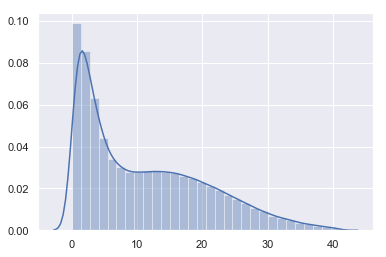

In [22]:
# re-display distribution of transaction amounts
amounts_list = [x for x in transcript['amount'] if x >= 0]
sns.distplot(amounts_list, bins=30);

In [44]:
"""print mean transaction amounts for different offer conditions"""

assert transcript.columns[-10] == 'o_1' # safety-check
transcript_trans = transcript.loc[transcript['event'] == 'transaction']
transcript_np = transcript_trans.loc[transcript_trans.iloc[: , -10:].count(axis=1) == 0]
transcript_nv = transcript_trans.loc[(transcript_trans.iloc[: , -10:].count(axis=1) > 0) & (transcript_trans.iloc[: , -10:].sum(axis=1) == 0)]
transcript_pv = transcript_trans.loc[transcript_trans.iloc[: , -10:].sum(axis=1) > 0]
assert (len(transcript_np)+len(transcript_nv)+len(transcript_pv)) == len(transcript_trans) # safety-check

print("mean transaction amount, no offer active: ", transcript_np['amount'].sum() / len(transcript_np))
print("mean transaction amount, offer active but not viewed / or completed: ", transcript_nv['amount'].sum() / len(transcript_nv))
print("mean transaction amount, offer active and viewed: ", transcript_pv['amount'].sum() / len(transcript_pv))

mean transaction amount, no offer active:  11.245539885886533
mean transaction amount, offer active but not viewed / or completed:  12.935618515878673
mean transaction amount, offer active and viewed:  9.704575629088897


C:\Users\r2d4\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


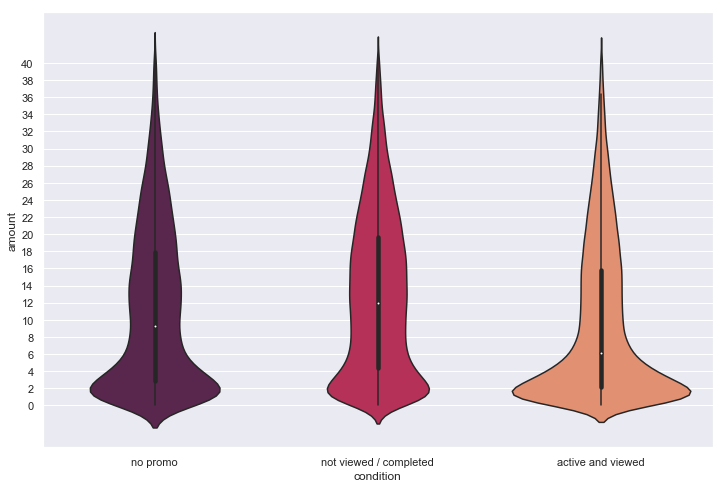

In [68]:
"""display transaction amount distribution for different offer conditions"""
# sns.boxplot(transcript_np['amount'], color=color)
# sns.boxplot(transcript_nv['amount'], color='yellow')
# # sns.boxplot(transcript_pv['amount'], color='red')

# categorize transactions according to three conditions
transcript_np['condition'] = 'no promo'
transcript_nv['condition'] = 'not viewed / completed'
transcript_pv['condition'] = 'active and viewed'
transcript_trans = pd.concat([transcript_np, transcript_nv, transcript_pv])
plt.figure(figsize=(12,8))
sns.violinplot(x='condition', y='amount', data=transcript_trans, palette="rocket")
plt.yticks(range(0,41,2));  # outliers cut off

**Observation: Mean transaction amount is much lower when customers spend under active and viewed conditions! (very surprising)**

Analysis of distribution shows that under active / viewed promo condition the customers tend to make a lot of smaller (0-4 $) transactions than if no promo is active or viewed. Question is: are those on top of the 'normal' spending behaviour?

C:\Users\r2d4\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


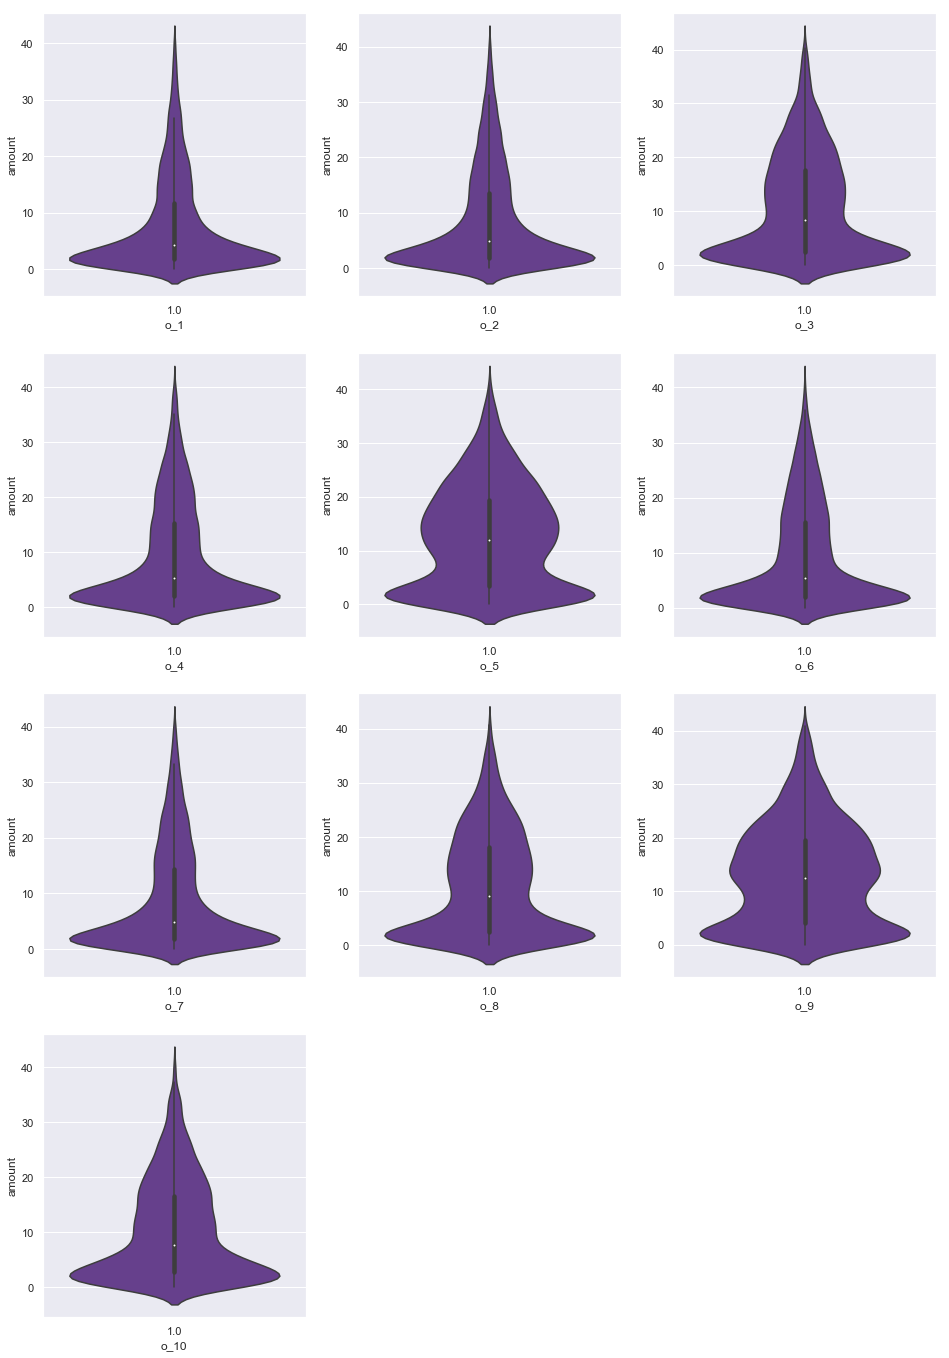

In [82]:
"""zoom in on transaction amount distribution for different offers"""

offer_list = transcript.columns[-10:]
plt.figure(figsize=(16, 24))

for pos, col in enumerate(offer_list):
    pos +=1
    temp = transcript_pv.loc[transcript_pv[col] == 1]
    plt.subplot((len(offer_list)/3) + 1, 3 , pos)
    sns.violinplot(x=col, y='amount', data=temp, color=color)

**Observation:** 
- This special distribution holds true for all offers, even the informational ones. 
- o_5, o_9, and to a lesser degree also o_3, o_8 and o_10 also have a higher share of transactions in the 10-20 $ range than the rest of the offers.

In [99]:
"""define function to create dataframe with KPIs per viewing for every offer"""

# create a look-up dict containing the duration for the different offers
duration_dict = dict(zip(portfolio.index, portfolio['duration']))


def calculate_offer_KPIs(df, portfolio=portfolio, duration_dict=duration_dict):
    """Calculate some KPI per viewing for every offer and return a dataframe
    containing them together with the basic offer characteristics.
    
    ARGUMENTS:
        - df: dataframe (flagged transcript data)
        - portfolio: dataframe, containing the basic offer characteristics
        - duration_dict: dict, containing offer ids as key, durations as values
      
    RETURNS:
        - offer_KPIs_df: dataframe, KPIs and basic characteristics
    """
    
    offer_KPIs = []
    
    for o_id in df.columns[-10:]:
        df_slice = df.loc[df[o_id] == 1, :]
        viewings = df_slice['event'].value_counts() ['offer viewed']
        transactions = df_slice['event'].value_counts() ['transaction']
        amount = df_slice['amount'].sum()
        days = duration_dict[o_id]
        if o_id in ['o_9', 'o_10']:
            completions = 0
        else:
            completions = df_slice['event'].value_counts() ['offer completed']

        offer_KPIs.append({'offer_id' : o_id,
                           'mean_complete' : completions / viewings,
                           'mean_trans' : transactions / viewings, 
                           'mean_amount' : amount / viewings, 
                           'mean_amount_day' : (amount / viewings) / days,
                           'mean_amount_trans' : amount / transactions,
                         })
        
    offer_KPIs_df = pd.DataFrame(offer_KPIs, columns = ['offer_id',
                                                        'mean_complete', 
                                                        'mean_trans',
                                                        'mean_amount',
                                                        'mean_amount_trans',
                                                        'mean_amount_day']).set_index('offer_id').sort_index()
    
    offer_KPIs_df = pd.concat([portfolio[['offer_type', 'difficulty', 'duration', 'reward', 'prop_rewards', 'rel_difficulty']], 
                               offer_KPIs_df], axis=1, sort=True).sort_values(['offer_type'])
    
    return offer_KPIs_df

In [100]:
# call function and display results
offer_KPIs_df = calculate_offer_KPIs(transcript)
display(offer_KPIs_df)

,offer_type,difficulty,duration,reward,prop_rewards,rel_difficulty,mean_complete,mean_trans,mean_amount,mean_amount_trans,mean_amount_day
o_1,bogo,10,7,10,1.000000,1.428571,0.386067,1.722846,13.545416,7.862230,1.935059
o_2,bogo,10,5,10,1.000000,2.000000,0.374065,1.290524,11.111340,8.609946,2.222268
o_3,bogo,5,7,5,1.000000,0.714286,0.508976,1.158903,12.572045,10.848225,1.796006
o_4,bogo,5,5,5,1.000000,1.000000,0.479349,1.091086,10.196551,9.345322,2.039310
o_5,discount,20,10,5,0.250000,2.000000,0.502452,1.443983,18.197386,12.602213,1.819739
o_6,discount,7,7,3,0.428571,1.000000,0.592441,1.317779,12.453055,9.450035,1.779008
o_7,discount,10,10,2,0.200000,1.000000,0.632269,1.706115,15.226739,8.924801,1.522674
o_8,discount,10,7,2,0.200000,1.428571,0.519970,1.175789,13.069430,11.115456,1.867061
o_10,informational,0,3,0,NaN,0.000000,0.000000,0.973466,10.103542,10.378937,3.367847
o_9,informational,0,4,0,NaN,0.000000,0.000000,1.014659,13.145608,12.955692,3.286402


**Note:** There are double counts in this calculation (the transactions that were assigned to more than one offer). So the figures for mean_transactions and mean_amount per viewing are some percentage points to high.

In [101]:
#display grouped by offer type
display(offer_KPIs_df.groupby(by='offer_type').agg(np.mean))

,difficulty,duration,reward,prop_rewards,rel_difficulty,mean_complete,mean_trans,mean_amount,mean_amount_trans,mean_amount_day
offer_type,,,,,,,,,,
bogo,7.50,6.0,7.5,1.000000,1.285714,0.437114,1.315840,11.856338,9.166431,1.998161
discount,11.75,8.5,3.0,0.269643,1.357143,0.561783,1.410917,14.736653,10.523126,1.747120
informational,0.00,3.5,0.0,NaN,0.000000,0.000000,0.994062,11.624575,11.667315,3.327125


**Observation: The mean amount spent per day is extremely high for the informational offers!**

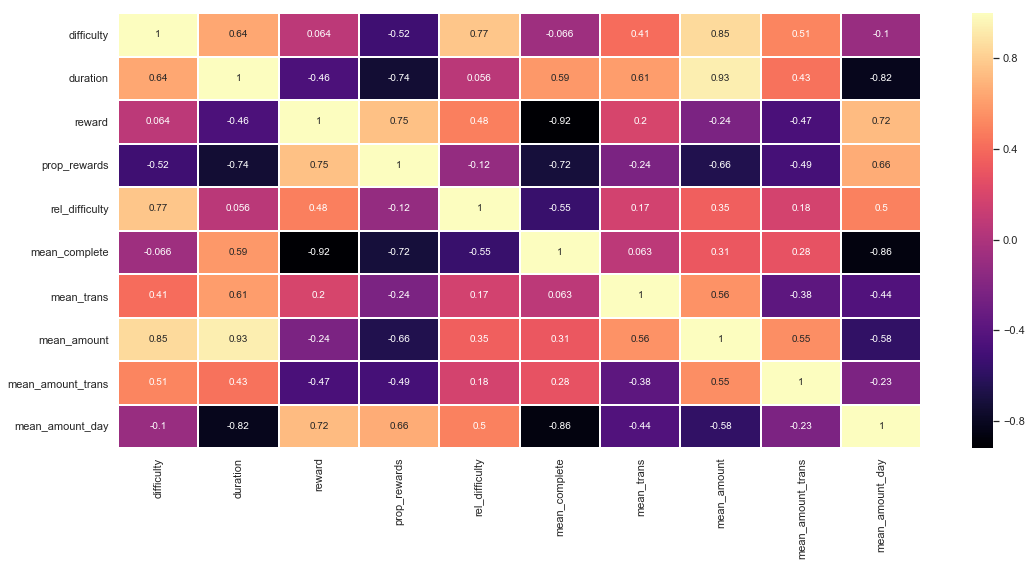

In [104]:
"""show correlation between numerical features in offer_KPIs_df - informational offers (o_9 & o_10) are removed"""

EDA.plot_num_corrMap(offer_KPIs_df.iloc[:-2 , :],  figsize=(18, 8))

**Observations:** Probably the most relevant feature to measure success is `mean_amount_day`, the daily spendings of customers while an offer was active and viewed. (Knowing that duration has an effect and that we don't know if there is a lasting effect after completion.) We fokus on correlations with that feature.
- higher duration has a clear negative correlation
- higher rewards have a clear positive correlation
- (rel difficulty too, but that has mainly to do with shorter duration)
- mean completion per viewing has a very strong negative correlation (suprising!)
- mean amount per viewing has also a negative effect (surprising!) as has, to a lesser extent, the mean amount per transaction

## Explore profile data

Note: Socio-demographic features for 2'175 customers missing, they won't be interfered for this analysis.

In [8]:
display(profile.head())
display(profile.info())

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,completed_viewed,total_trans,total_amount,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount
person_id,,,,,,,,,,,,,,,,
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,2.0,9.0,20.40,2.266667,0,0.00,0.000000,0.000000,0.000000
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.0,6.0,15.62,2.603333,3,7.69,2.563333,0.500000,0.492318
p_100,68.0,F,84000.0,-725,5.0,0.0,1.0,0.0,2.0,34.04,17.020000,2,34.04,17.020000,1.000000,1.000000
p_1000,67.0,M,44000.0,-225,4.0,4.0,0.0,0.0,5.0,19.78,3.956000,2,13.37,6.685000,0.400000,0.675935
p_10000,NaN,NaN,NaN,-446,3.0,3.0,0.0,0.0,6.0,7.28,1.213333,1,1.83,1.830000,0.166667,0.251374


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 16 columns):
age                  14825 non-null float64
gender               14825 non-null category
income               14825 non-null float64
member_days          17000 non-null int64
offer_received       17000 non-null float64
offer_viewed         17000 non-null float64
offer_completed      17000 non-null float64
completed_viewed     17000 non-null float64
total_trans          17000 non-null float64
total_amount         17000 non-null float64
total_mean_amount    17000 non-null float64
np_trans             17000 non-null int64
np_amount            17000 non-null float64
np_mean_amount       17000 non-null float64
prop_np_trans        17000 non-null float64
prop_np_amount       17000 non-null float64
dtypes: category(1), float64(13), int64(2)
memory usage: 2.1+ MB


None

In [9]:
profile.describe()

,age,income,member_days,offer_received,offer_viewed,offer_completed,completed_viewed,total_trans,total_amount,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount
count,14825.000000,14825.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,54.393524,65404.991568,-517.449882,4.486882,3.395588,1.975235,1.366882,8.173706,104.438351,13.340673,4.103824,59.090054,12.723255,0.494278,0.491477
std,17.383705,21598.299410,411.223904,1.076165,1.297653,1.605563,1.280864,5.116250,125.922619,15.998435,3.202224,89.982513,19.417294,0.264600,0.282580
min,18.000000,30000.000000,-1823.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,-791.000000,4.000000,2.750000,1.000000,0.000000,4.000000,21.820000,3.040000,2.000000,7.247500,2.605000,0.333333,0.288846
50%,55.000000,64000.000000,-358.000000,5.000000,3.000000,2.000000,1.000000,7.000000,69.405000,11.413523,3.000000,30.825000,9.932778,0.500000,0.507398
75%,66.000000,80000.000000,-208.000000,5.000000,4.000000,3.000000,2.000000,11.000000,148.782500,20.242654,6.000000,84.332500,19.632500,0.666667,0.695792
max,101.000000,120000.000000,0.000000,6.000000,6.000000,6.000000,6.000000,36.000000,1608.690000,451.470000,27.000000,1304.990000,855.310000,1.000000,1.000000


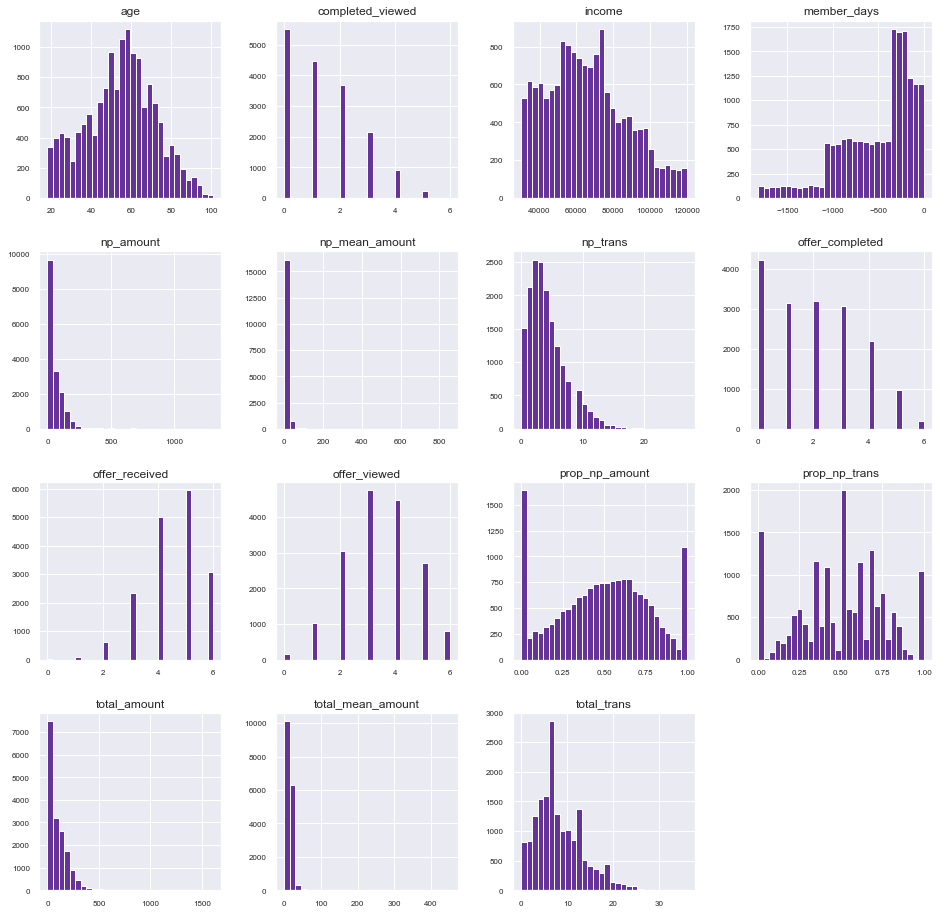

In [10]:
"""plot histograms of numerical data""" # note socio-demographic features missing for 2'175 customers

EDA.plot_num_hist(profile, figsize=(16, 16), bins=30)

**Observations:**
- most customers viewed 4-5 offers, and viewed 3-4 of them
- most customers make approx. 4-12 transactions a month (test period)
- approx 10% of customers have only spent money when an offer was active, approx. 7% only when no offer was active

It's probably not easy to evade offer related transactions if you make a lot of transactions, as there often is an offer (or two) active. You can also see that the number of non-promo related transactions declines quite fast.

In [118]:
"""remove oultiers"""

# count outliers (<> IQR=1.5)
cleaning.count_outliers_IQR_method(profile)

age
Identified outliers: 0
Percentage of outliers: 0.0%

income
Identified outliers: 0
Percentage of outliers: 0.0%

member_days
Identified outliers: 287
Percentage of outliers: 1.7%

offer_received
Identified outliers: 689
Percentage of outliers: 4.1%

offer_viewed
Identified outliers: 981
Percentage of outliers: 5.8%

offer_completed
Identified outliers: 0
Percentage of outliers: 0.0%

completed_viewed
Identified outliers: 16
Percentage of outliers: 0.1%

total_trans
Identified outliers: 296
Percentage of outliers: 1.7%

total_amount
Identified outliers: 521
Percentage of outliers: 3.1%

total_mean_amount
Identified outliers: 260
Percentage of outliers: 1.5%

np_trans
Identified outliers: 330
Percentage of outliers: 1.9%

np_amount
Identified outliers: 630
Percentage of outliers: 3.7%

np_mean_amount
Identified outliers: 194
Percentage of outliers: 1.1%

prop_np_trans
Identified outliers: 0
Percentage of outliers: 0.0%

prop_np_amount
Identified outliers: 0
Percentage of outliers: 0.

In [119]:
# clean outliers for total transactions and total amount
cleaning.remove_outliers_IQR_method(profile, outlier_cols=['total_amount', 'total_trans', 'total_mean_amount'])
len(profile)

total_amount
Rows removed: 521

total_trans
Rows removed: 265

total_mean_amount
Rows removed: 7


Rows removed in total: 793



16207

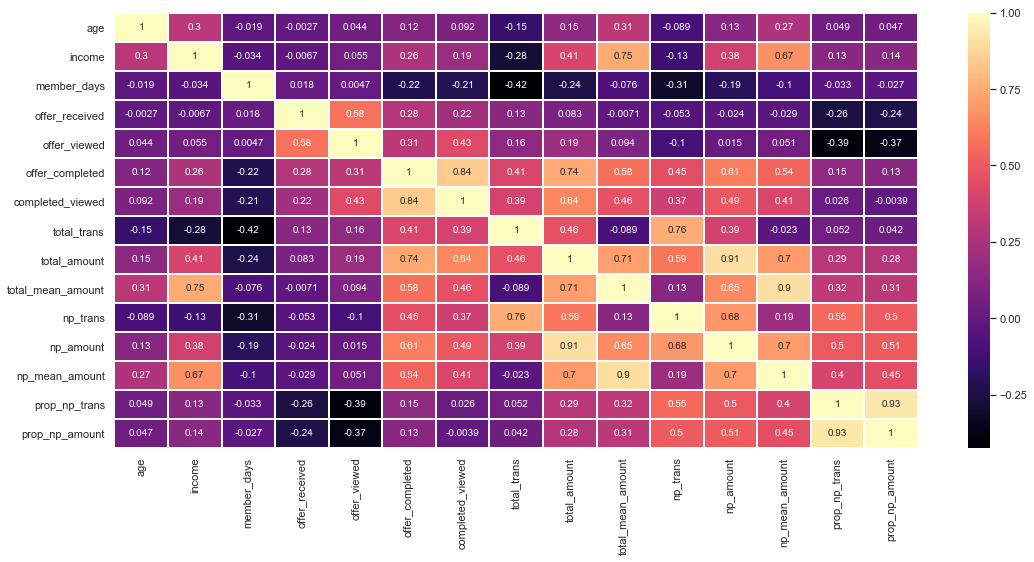

In [121]:
"""show correlation between numerical features"""

EDA.plot_num_corrMap(profile, figsize=(18, 8))

**Observations:**

With regard to `total_amount`:
- income has a positive correlation, age a weak one, newer members tend to spend a little more
- number of viewed offers has a weak positive correlation, number of completed ones a stronger (good!)
- non-promo amount and transactions (somewhat less) have a high positive correlation (understandably)

With regard to `prop_np_trans` / `prop_np_amount`:
- income has a weak positive correlation
- received and viewed offers a moderate negative one (first one is clear, less non-offer time, but note the difference!)
- offer completed has a weak positive correlation (affect spending in np periods positively)
- total transactions has no effect (interesting! I thought it would be positive ...)

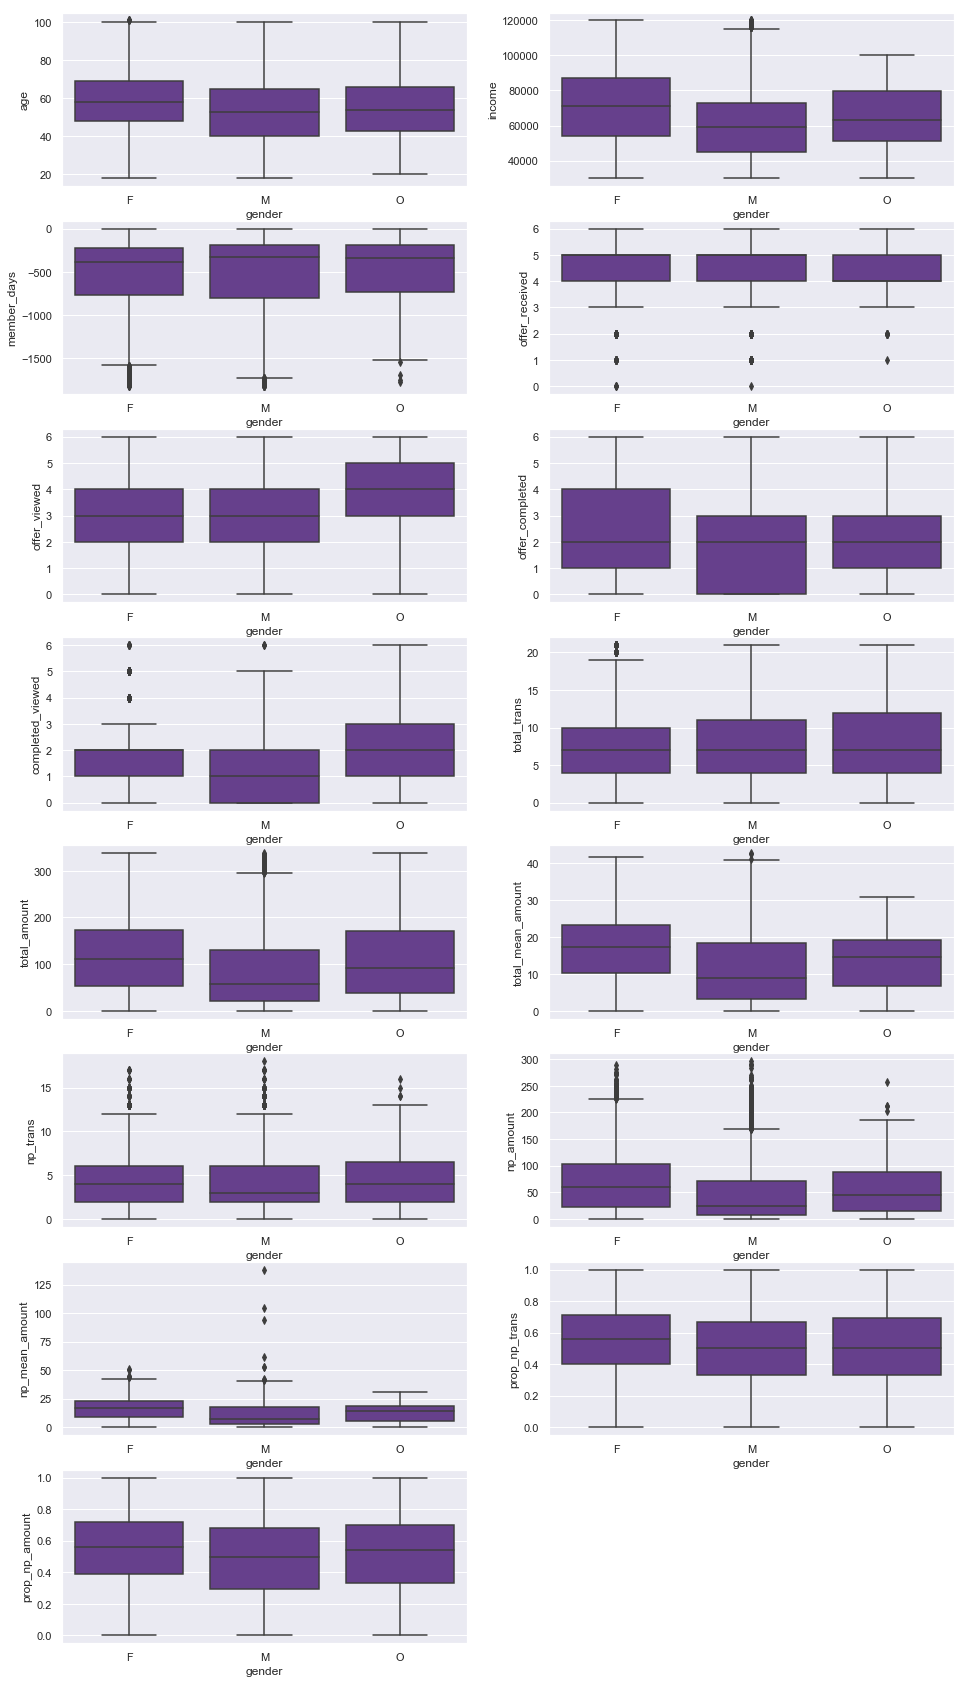

In [136]:
"""show correlation between gender (category) and numerical features""" # note gender is missing for 2'175 customers

EDA.plot_num_corrBox(profile, 'gender', figsize=(16, 30))

**Observations**: 

(Category 'O' (others) is too small to be relevant, so it is not analyzed, but generally it behaves more like women than men.)

- Women tend to be slightly older and to earn more than men.
- All genders receive and view the same mean amount of offers, but women complete them slightly more often (!).
- The number of transactions is about the same, but women spend much more in total.
- The proportion of non-promo transactions / amounts is slightly higher for women.

Only looking at this data one could generalize: the mean woman is generally more sensitive to offers (and completes more of them than the mean male), but at the same time she doesn't slow down her consumption when no offer is active. She shops as often as the mean man does, but spends much more.

C:\Users\r2d4\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


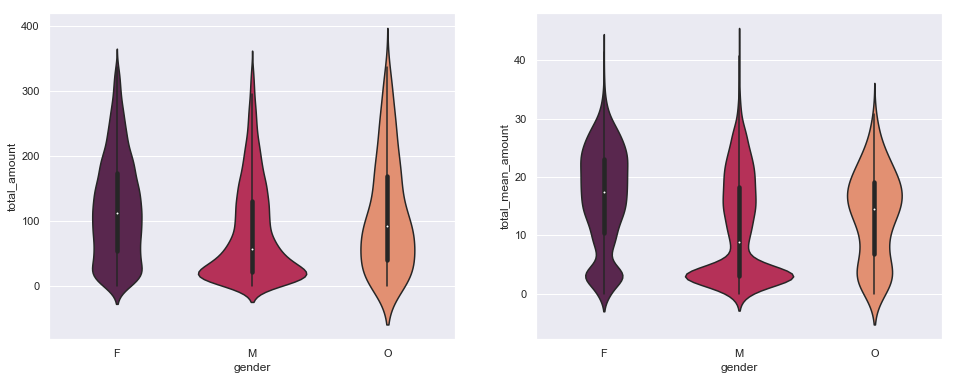

In [137]:
"""zoom in on distribution of total amounts and mean amounts per transactions by gender"""

plt.figure(figsize=(16, 6))
plt.subplot(1, 2 , 1)
sns.violinplot(x='gender', y='total_amount', data=profile, palette="rocket")
plt.subplot(1, 2 , 2)
sns.violinplot(x='gender', y='total_mean_amount', data=profile, palette="rocket");

**Observation:** It's mostly men who are responsible for these low amount transactions we have observed to be mostly take place in active offer conditions (see transcript EDA).

### Focus: 'High_p' vs. 'High_np'

Explore possible differences between customers with high and low proportion of non-promo spendings
- high_p: spend most on promos
- high_np: spend a lot when no promo is viewed / active

In [138]:
"""analyze groups `high_p` vs `high_np` - high spenders with clear pattern towards promo or non-promo spending"""

# select customers with spending > 20 and >= 4 transactions, subselect and label those leaning towards p or np
profile_high = profile.loc[(profile['total_amount'] > 20) & (profile['total_trans'] >= 4)]
profile_high['group'] = np.where((profile_high['prop_np_amount'] > 0.75), 'h_np', 'h_middle')
profile_high['group'] = np.where((profile_high['prop_np_amount'] < 0.33), 'h_p', profile_high['group'])

# check results
profile_high['group'].value_counts()

C:\Users\r2d4\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\r2d4\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


h_middle    6909
h_p         2292
h_np        1798
Name: group, dtype: int64

In [139]:
# print some statistics concerning this selection
print("customers in selection: {}, proportion of total: {:.3f}".format(len(profile_high), (len(profile_high) /len(profile))))
print("cumulative spendings:  {}, proportion of total: {:.3f}".format(profile_high['total_amount'].sum(), 
    (profile_high['total_amount'].sum()/profile['total_amount'].sum())))

customers in selection: 10999, proportion of total: 0.679
cumulative spendings:  1321939.88, proportion of total: 0.925


In [145]:
# to make distinctions clearer, drop all 'middle' customers 
profile_high = profile_high.loc[profile_high['group'] != 'h_middle']
print("remaining customers in selection: ",len(profile_high))

remaining customers in selection:  4090


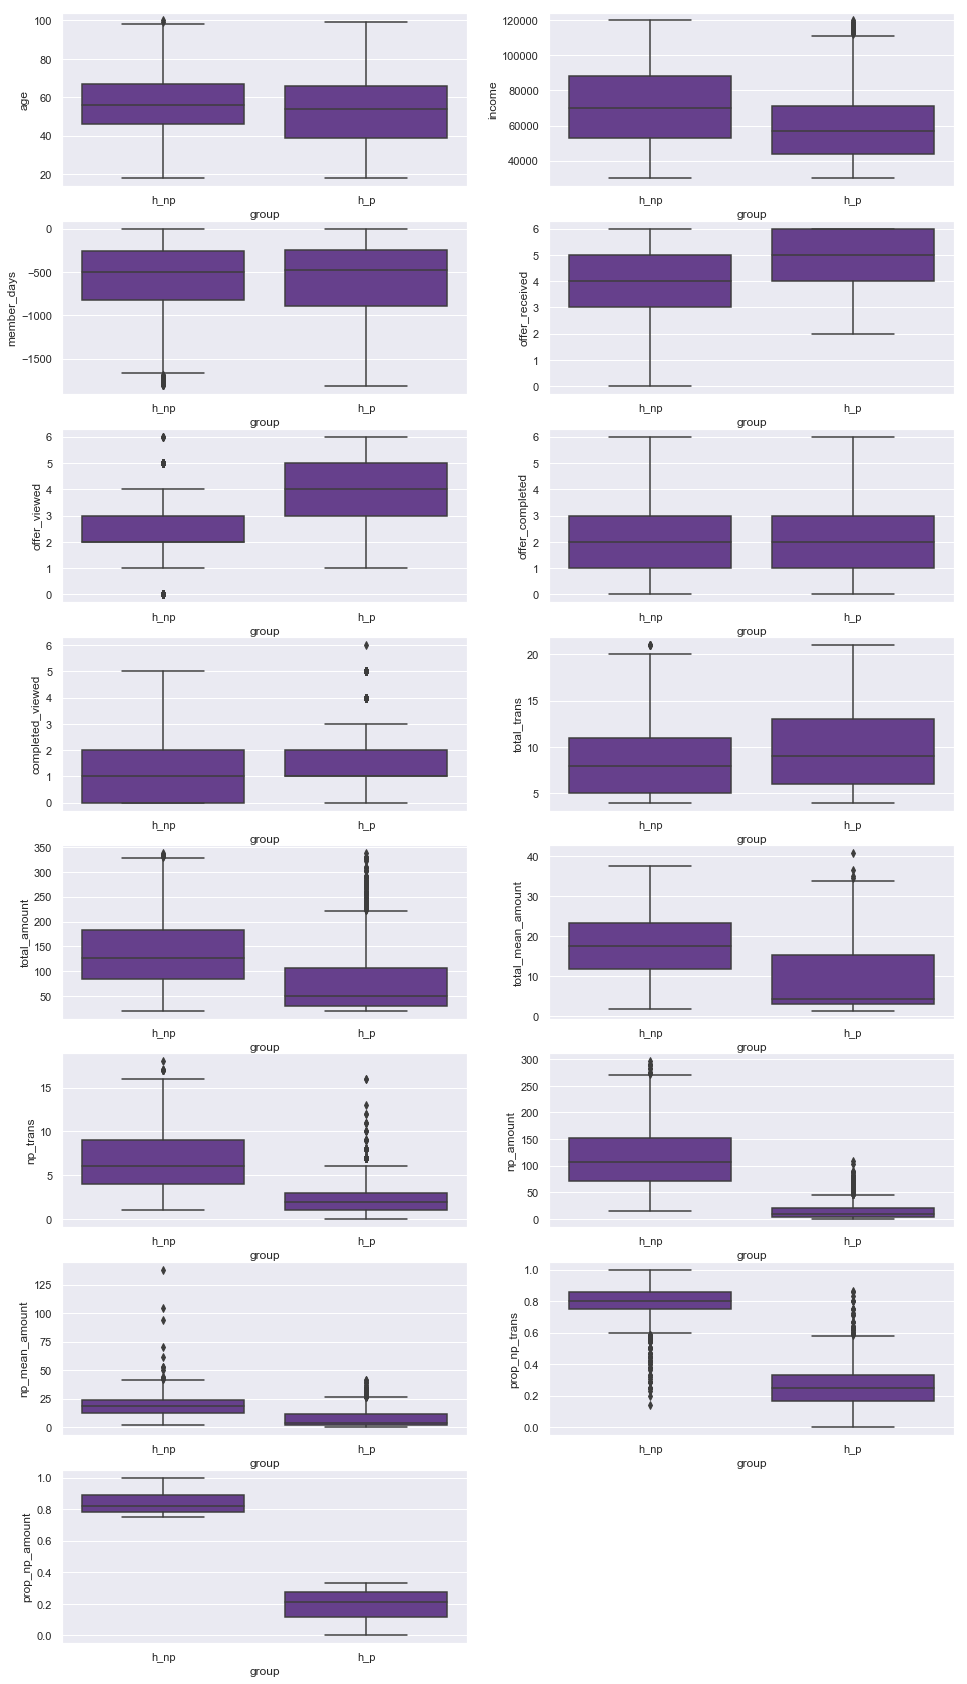

In [147]:
EDA.plot_num_corrBox(profile_high, 'group', figsize=(16, 30))

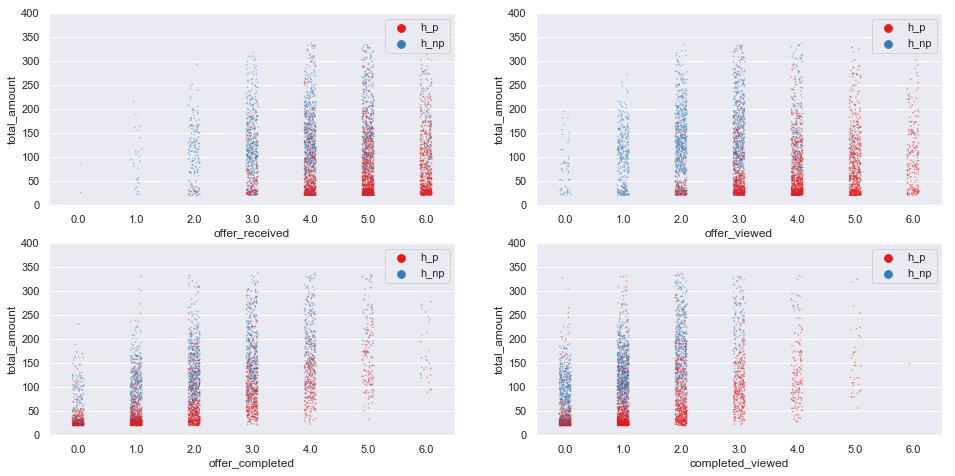

In [144]:
"""zoom in on offer data, in relation to total amount for both groups"""

zoom_list = ['offer_received', 'offer_viewed', 'offer_completed', 'completed_viewed']
plt.figure(figsize=(16,12))

for pos, col in enumerate(zoom_list):
    pos +=1
    plt.subplot((len(zoom_list)/2) + 1, 2 , pos)
    sns.stripplot(x=col, y='total_amount', data=profile_high, hue='group', palette="Set1", jitter=True, alpha=0.5, size=1.5)
    plt.ylim([0, 400])  #  outliers cut off
    plt.legend(loc='upper right');

**Observations:**
- high_p have lower income than high_np
- high_p receive more offers *
- high_p view offers closely, high_np tend to 'miss' a couple of them (but complete them partialy by 'accident')
- high_p who complete 1-2 offers do this on very low spending (not much up-selling effect)
- high_p tend to spend much less on average than high_np (see below), but they make slightly more transactions (interesting)
- high_p are responsible for most of those very small transactions

- high_np look at significantly lesser offers than p, but they complete as many. Half of the offers they complete are by pure chance, as they have never looked at them. For p the ratio is higher, they have seen about 2/3 of the completed offers.

_* this probably shows, that it is quite difficult to make a high share of np transactions when there are many offers running (what means that you look at your app from time to time)_

(0, 40)

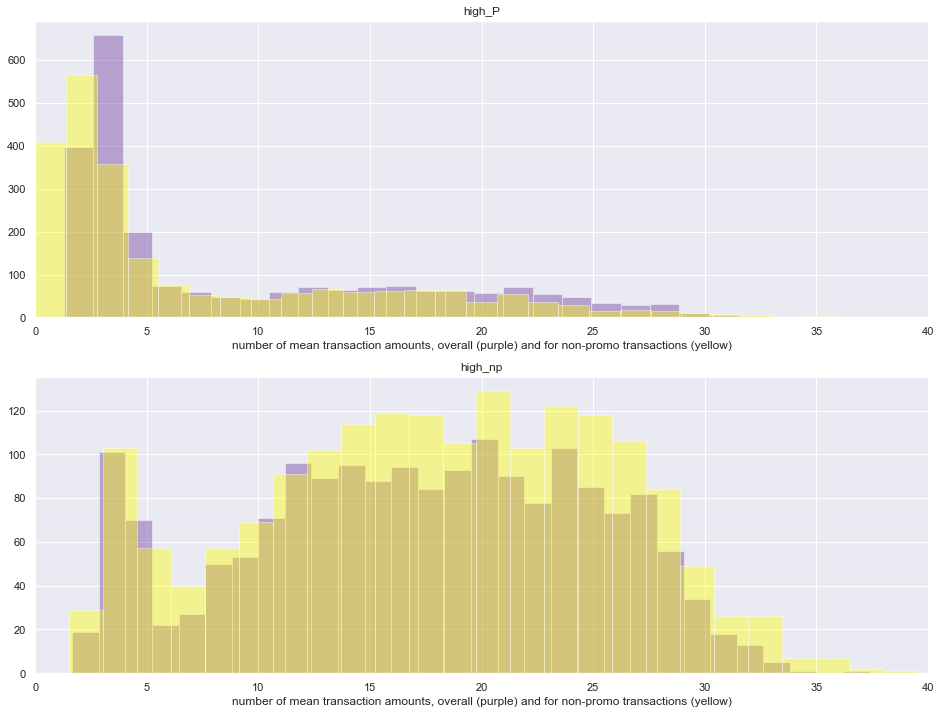

In [163]:
"""zoom in on mean transaction amounts for the two groups"""

plt.figure(figsize=(16,12))
plt.subplot(2,1,1)
sns.distplot(profile_high['total_mean_amount'][profile_high['group'] == "h_p"], kde=False, bins=30, color=color)
sns.distplot(profile_high['np_mean_amount'][profile_high['group'] == "h_p"], kde=False, bins=30, color='yellow')
plt.xlabel("number of mean transaction amounts, overall (purple) and for non-promo transactions (yellow)")
plt.title('high_P')
plt.xlim([0, 40])

plt.subplot(2,1,2)
sns.distplot(profile_high['total_mean_amount'][profile_high['group'] == "h_np"], kde=False, bins=30, color=color)
sns.distplot(profile_high['np_mean_amount'][profile_high['group'] == "h_np"], kde=False, bins=90, color='yellow')
plt.xlabel("number of mean transaction amounts, overall (purple) and for non-promo transactions (yellow)")
plt.title('high_np')
plt.xlim([0, 40])